In [79]:
#En este ejemplo vamos a coger los puntos del xml de paparazzi, vamos a optimizar el camino con un TSP y posteriormente vamos a 
#calcular las curvas de Bezier mas óptimas

In [80]:
#Cargamos los módulos que se van a necesitar
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

In [81]:
from lxml import etree

# Ruta a tu archivo XML y DTD
xml_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V3_optimizar.xml'
dtd_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/flight_plan.dtd'

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


Error de sintaxis XML:
XML declaration allowed only at the start of the document, line 2, column 6 (<string>, line 2)


In [82]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#2- Coordenadas.txt -> Nos dice las coordenadas de los puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#flightplan_entrada = input("Introduce el archivo que quiere optimizar con la extensión .xml: ")
#flightplan_salida = input("Introduce como quiere llamar archivo de salida con .xml: ")

#Leemos los archivos sacados del boton de planificación
Estrategia = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/datos.txt', delimiter=':', header = None) #Datos.txt
Coordenadas = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/coordenadas.txt', delimiter=',', header=None) #Coordenadas.txt

#Carga de archivo XML
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V3_optimizar.xml')
root = tree.getroot()

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []
home=[]
#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        lat = float(waypoint.get('lat'))
        lon = float(waypoint.get('lon'))
        #x = float(waypoint.get('x'))
        #y = float(waypoint.get('y'))
        #print(waypoint.get('lat'))
        #print(lon)
        #print(type(lat))
        #waypoint_list.append((name, x, y))
        waypoint_list.append((name, lat, lon))
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        if name == "HOME":
            home.append((name, x, y))
        #print(unchanged_points)
        
#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
points = np.concatenate((waypoints, unchangedpoints), axis=0)


#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = (waypoints[:,-2:])
print(paradas)
#Definimos parámetros del barco
velocidad_media = 40

ParseError: XML or text declaration not at start of entity: line 2, column 0 (<string>)

In [83]:
def closest_point_and_reorder(home, points):

    # Convertir las coordenadas de los puntos a un numpy array y trabajar solo con las coordenadas (últimas 2 columnas)
    coords = np.array(points[:, -2:], dtype=float)
    
    # Convertir el punto fijo a un array numpy
    home = np.array(home, dtype=float)
    
    # Calcular las distancias euclidianas entre el punto fijo y cada punto de 'coords'
    distances = np.linalg.norm(coords - home, axis=1)
    
    # Encontrar el índice del punto con la menor distancia
    closest_index = np.argmin(distances)
    
    # Reordenar los puntos colocando el más cercano en la primera posición
    reordered_points = np.vstack([points[closest_index], np.delete(points, closest_index, axis=0)])
    
    return reordered_points


In [58]:
home_coord = home[0][1:]
waypoint_list = [(x, y) for (_, x, y) in waypoint_list]
waypoint_list = closest_point_and_reorder(home_coord, paradas)

In [59]:
waypoint_list

array([['40.450733', '-3.727176'],
       ['40.4509659', '-3.7271581'],
       ['40.450878', '-3.727239'],
       ['40.4507369', '-3.7271539']], dtype='<U32')

In [60]:
#Ahora una vez tenemos los puntos vamos a añadir el algoritmo de optimización

#COSA TO DO DESPUÉS DE HABER LOGRADO UNIR EL OPTIMIZADOR CON LA RECOGIDA DE DATOS: FIJAR EL PUNTO INICIAL Y FINAL
stops=paradas

#Definimos el problema
class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):
        
        start_idx = 0  # Primer punto
        end_idx = len(waypoints)-1 # Último punto
        
        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)
        self.start_idx = start_idx
        self.end_idx = end_idx
        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=1,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    #Definimos las funciones de evaluación y las reestricciones
    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        #Max_dist=self.get_route_length(x)-250
        
        #Max_tiempo=self.get_route_length(x)/velocidad_media-250

        #x_ord=np.sort(x)
        #penalty_paradas=0
        #for i in range(len(x_ord)-1):
        #   if x_ord[i] == x_ord[i+1]:
        #       penalty_paradas=10000
        g1 = 1 if x[0] != self.start_idx else 0  # Penaliza si el primer punto no es start_idx
        g2 = 1 if x[-1] != self.end_idx else 0   # Penaliza si el último punto no es end_idx
        #out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
        out["G"] = [g1, g2]

    #Distancia de la ruta
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist

#Visualización de los resultados
def visualize_3(problem, x, n, fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):
        # Asegúrate de que x sea un array unidimensional
        x = np.asarray(x)  # Convierte x a un array de numpy

        if x.ndim == 1:  # Asegúrate de que es un vector
            x = x.flatten()  # Aplana el array para asegurarte de que sea 1D

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # Plot de las ciudades usando scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # Anota las ciudades
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # Plotea la línea en el camino
        for i in range(len(x) - 1):
            current = int(x[i])  # Asegúrate de convertir a entero
            next_ = int(x[i + 1])  # Asegúrate de convertir a entero
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        fig.suptitle(f"Route length: {problem.get_route_length(x)} km \nRoute time: {problem.get_route_length(x) * 60 / velocidad_media} min")

        if show:
            plt.show()

In [61]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas
#De momento dejaremos el n_barcos fijos igual a 1 pero el algoritmo está preparado para que en algún momento se puedan añadir más
n_barcos = 1

style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0
[0 2 1 3]


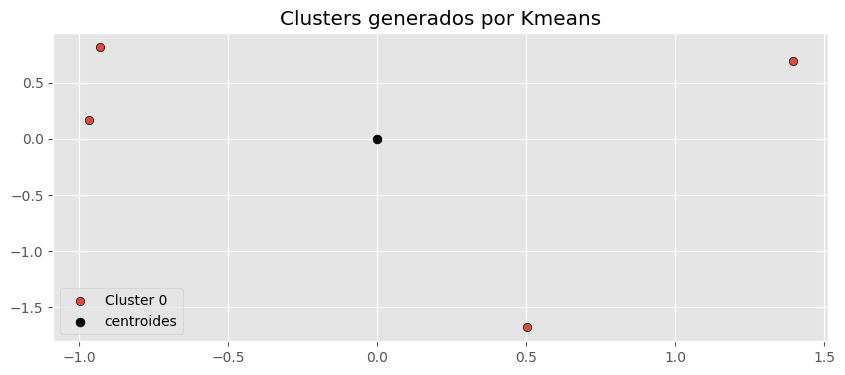

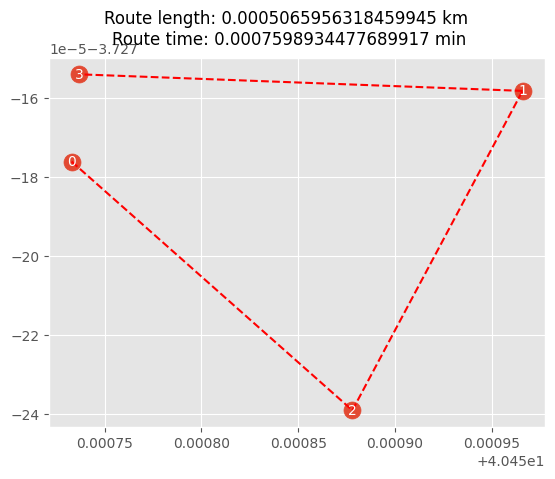

In [62]:
#Creamos un diccionario para almacenar cada ruta
rutas={}
stops = waypoint_list.astype(float)
#print(stops)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:, 0], stops[:, 1], y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)
            
    #Muestra
    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )

    #Optimización    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    #print("Maximum Span:", np.round(res.F[0], 3))
    #print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos)
    


In [63]:
dtype = [('nombre', 'U10'), ('lat', 'f4'), ('lon', 'f4')]  # U10 para string, f4 para float
resultado = np.zeros(len(res.X),dtype=dtype)

for i in range(len(res.X)):
    idx = res.X[i]
    
    resultado[i] = (f'BZ{i}', waypoint_list[idx, 0], waypoint_list[idx, 1])

In [64]:
res.X

array([0, 2, 1, 3])

In [65]:
waypoint_list

array([['40.450733', '-3.727176'],
       ['40.4509659', '-3.7271581'],
       ['40.450878', '-3.727239'],
       ['40.4507369', '-3.7271539']], dtype='<U32')

In [66]:
resultado

array([('BZ0', 40.450733, -3.727176), ('BZ1', 40.45088 , -3.727239),
       ('BZ2', 40.450966, -3.727158), ('BZ3', 40.450737, -3.727154)],
      dtype=[('nombre', '<U10'), ('lat', '<f4'), ('lon', '<f4')])

In [68]:
Puntos_paso = np.vstack((resultado['lat'], resultado['lon'])).T
Puntos_paso

array([[40.450733, -3.727176],
       [40.45088 , -3.727239],
       [40.450966, -3.727158],
       [40.450737, -3.727154]], dtype=float32)

In [69]:
#Ahora viene la implementación de las curvas de Bezier

In [70]:
from scipy.special import comb

def get_bezier_parameters(X, Y, smooth_factor, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.

    Based on https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    and probably on the 1998 thesis by Tim Andrew Pastva, "Bézier Curve Fitting".
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    #if len(X) < degree + 1:
    #    raise ValueError(f'There must be at least {degree + 1} points to '
    #                     f'determine the parameters of a degree {degree} curve. '
    #                     f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M, smooth_factor):
        M_ = np.linalg.pinv(M)
        
        smooth_matrix = np.eye(M.shape[1])
        for i in range(1, M.shape[1]):
            smooth_matrix[i, i - 1] = -1  # Penaliza diferencias grandes entre puntos de control adyacentes

        # Combine the original fitting problem with the smoothness constraint
        augmented_matrix = np.vstack([M, smooth_factor * smooth_matrix])
        augmented_points = np.vstack([points, np.zeros((smooth_matrix.shape[0], points.shape[1]))])
        
        return np.linalg.pinv(augmented_matrix) @ augmented_points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M, smooth_factor).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

In [71]:
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=50):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [72]:
#Añadimos los puntos
points = []
xpoints = Puntos_paso[:,0]
ypoints = Puntos_paso[:,1]
for i in range(len(xpoints)):
    points.append([xpoints[i],ypoints[i]])

[[40.450733, -3.727176], [40.21630713278836, -3.7056238420343255], [40.41737279512425, -3.7241807342015902], [40.529241052299035, -3.7344854416414686], [40.541241112973346, -3.7355525528501814], [40.49092635483486, -3.7308613247378855], [40.4346268444151, -3.725630642669819], [40.409895959401666, -3.723339763556133], [40.420698530832574, -3.724352803023792], [40.450737, -3.727154]]
[40.450733, 40.21630713278836, 40.41737279512425, 40.529241052299035, 40.541241112973346, 40.49092635483486, 40.4346268444151, 40.409895959401666, 40.420698530832574, 40.450737]
[-3.727176, -3.7056238420343255, -3.7241807342015902, -3.7344854416414686, -3.7355525528501814, -3.7308613247378855, -3.725630642669819, -3.723339763556133, -3.724352803023792, -3.727154]
Len:  8


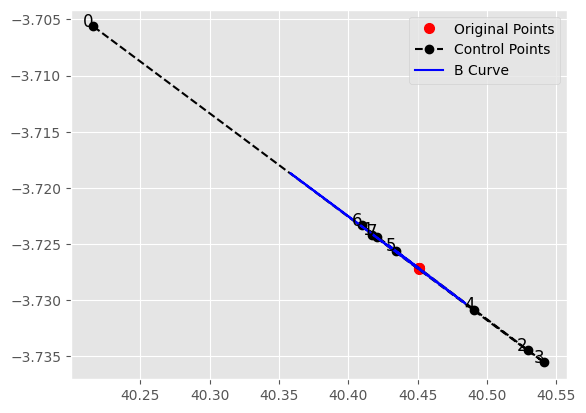

In [73]:
import matplotlib.pyplot as plt
# Plot the original points
plt.plot(xpoints, ypoints, "ro", markersize = 7, label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, 0.11, degree=len(xpoints)*2+1) #BZ0 BZ5 BZ8 BZ11 son los de paso, por tanto habrá 4*2 + 1 puntos de contol ya que el algoritmo te pone 1 pnt cntrl en el 1 punto y en el último

x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
print(data)
print(x_val)
print(y_val)
x_val = np.delete(x_val, 0)
x_val = np.delete(x_val, -1)
y_val = np.delete(y_val, 0)
y_val = np.delete(y_val, -1)
print("Len: ",len(x_val))

# Añadir etiquetas de los índices
for i, (xi, yi) in enumerate(zip(x_val, y_val)):
    plt.text(xi, yi, str(i), fontsize=12, ha='right')


# Plot the control points
plt.plot(x_val,y_val,'k--o', label='Control Points')
# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
#plt.xlim(40, 40.5)
#plt.ylim(-3.72725, -3.72580)
plt.plot(xvals, yvals, 'b-', label='B Curve')
plt.legend()
plt.show()

In [74]:
#Ahora que ya tenemos los puntos de paso y de control necesitamos llevarlo a paparazzi en un xml

#Hay que tener en cuenta lo siguiente: Después de BZ0 -> 4 pnts control, luego entre punto y punto habrá 2 de control
Puntos_control = np.array([x_val, y_val]).T
Total_puntos = Puntos_control.shape[0] + Puntos_paso.shape[0]
Puntos_Bezier = np.zeros((Total_puntos, Puntos_control.shape[1]))

#Añadimos en primer lugar BZ0 y los 4 puntos de control

Puntos_Bezier[0] = Puntos_paso[0]
for i in range(1, 5, 1):
    print(i)
    Puntos_Bezier[i] = Puntos_control[i-1]

idx_control = 4
idx_paso = 1

for i in range(5, len(Puntos_Bezier), 3):
    if idx_paso<=len(Puntos_paso)-1:
        print("Paso: ", idx_paso)
        print("Punto añadido: ", Puntos_paso[idx_paso])
        Puntos_Bezier[i] = Puntos_paso[idx_paso]
        idx_paso += 1
    if idx_control<=len(Puntos_control)-1:
        print("Control 1:", idx_control)
        print("Punto añadido: ", Puntos_control[idx_control])
        Puntos_Bezier[i+1] = Puntos_control[idx_control]
        idx_control += 1
    if idx_control<=len(Puntos_control)-1:
        print("Control 2:", idx_control)
        print("Punto añadido: ", Puntos_control[idx_control])
        Puntos_Bezier[i+2] = Puntos_control[idx_control]
        idx_control += 1
    print(Puntos_Bezier)

1
2
3
4
Paso:  1
Punto añadido:  [40.45088  -3.727239]
Control 1: 4
Punto añadido:  [40.49092635 -3.73086132]
Control 2: 5
Punto añadido:  [40.43462684 -3.72563064]
[[40.45073318 -3.72717595]
 [40.21630713 -3.70562384]
 [40.4173728  -3.72418073]
 [40.52924105 -3.73448544]
 [40.54124111 -3.73555255]
 [40.45087814 -3.72723889]
 [40.49092635 -3.73086132]
 [40.43462684 -3.72563064]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Paso:  2
Punto añadido:  [40.450966 -3.727158]
Control 1: 6
Punto añadido:  [40.40989596 -3.72333976]
Control 2: 7
Punto añadido:  [40.42069853 -3.7243528 ]
[[40.45073318 -3.72717595]
 [40.21630713 -3.70562384]
 [40.4173728  -3.72418073]
 [40.52924105 -3.73448544]
 [40.54124111 -3.73555255]
 [40.45087814 -3.72723889]
 [40.49092635 -3.73086132]
 [40.43462684 -3.72563064]
 [40.45096588 -3.72715807]
 [40.40989596 -3.72333976]
 [40.42069853 -3.7243528 ]
 [ 0.          0.        ]]
Paso:  3
Punto añadido:  [40

In [75]:
print("Paso:\n", Puntos_paso)

print("Control:\n", Puntos_control)

print("Bezier:\n", Puntos_Bezier)

Paso:
 [[40.450733 -3.727176]
 [40.45088  -3.727239]
 [40.450966 -3.727158]
 [40.450737 -3.727154]]
Control:
 [[40.21630713 -3.70562384]
 [40.4173728  -3.72418073]
 [40.52924105 -3.73448544]
 [40.54124111 -3.73555255]
 [40.49092635 -3.73086132]
 [40.43462684 -3.72563064]
 [40.40989596 -3.72333976]
 [40.42069853 -3.7243528 ]]
Bezier:
 [[40.45073318 -3.72717595]
 [40.21630713 -3.70562384]
 [40.4173728  -3.72418073]
 [40.52924105 -3.73448544]
 [40.54124111 -3.73555255]
 [40.45087814 -3.72723889]
 [40.49092635 -3.73086132]
 [40.43462684 -3.72563064]
 [40.45096588 -3.72715807]
 [40.40989596 -3.72333976]
 [40.42069853 -3.7243528 ]
 [40.450737   -3.72715402]]


In [76]:
# Ahora hay que meter estos puntos en el xml

# Añadimos una columna de ceros donde meteremos los nombres
Columna_nombres = np.zeros(Puntos_Bezier.shape[0], dtype=object)  # Cambiado a un vector de tamaño adecuado

dtype = [('nombre', 'U10'), ('lat', 'f4'), ('lon', 'f4')]  # U10 para string, f4 para float

# Concatenar la columna de nombres y Puntos_Bezier
resultado = np.empty(len(Columna_nombres), dtype=dtype)  # Crear un array vacío del tipo correcto
resultado['nombre'] = Columna_nombres  # Asignar la columna de nombres
resultado['lat'] = Puntos_Bezier[:, 0]  # Asignar la columna x
resultado['lon'] = Puntos_Bezier[:, 1]  # Asignar la columna y

unchanged_array = np.zeros(len(unchangedpoints), dtype=dtype)

# Ponemos el nombre en la columna correspondiente
for i in range(len(resultado)):
    resultado[i]['nombre'] = f'BZ{i}'
print(resultado)

# Rellenamos este array
for i, (nombre, x_str, y_str) in enumerate(unchangedpoints):
    #print("x: ", x_str)
    #print("y: ", y_str)
    #print("Nombre: ", nombre)
    unchanged_array[i] = (nombre, float(x_str), float(y_str)) 


[('BZ0', 40.450733, -3.727176 ) ('BZ1', 40.21631 , -3.7056239)
 ('BZ2', 40.417374, -3.7241807) ('BZ3', 40.52924 , -3.7344854)
 ('BZ4', 40.54124 , -3.7355525) ('BZ5', 40.45088 , -3.727239 )
 ('BZ6', 40.490925, -3.7308614) ('BZ7', 40.434628, -3.7256308)
 ('BZ8', 40.450966, -3.727158 ) ('BZ9', 40.409897, -3.7233398)
 ('BZ10', 40.4207  , -3.7243528) ('BZ11', 40.450737, -3.727154 )]


In [78]:
#Si se añade para que vaya más de un barco esto habrá que modificarlo para que cree diferentes archivos
# Reescribir todos los waypoints organizados desde 'resultados'

for name, x, y in resultado:
    new_waypoint = ET.Element('waypoint', x=str(x), y=str(y), name=name)
    way_points.append(new_waypoint)
for name, x, y in unchangedpoints:
    new_unchanged = ET.Element('waypoint', name=name, x=str(x), y=str(y))
    way_points.append(new_unchanged)

# Función para formatear el XML
def prettify(element):
    """ Devuelve una versión 'bonita' del XML """
    rough_string = ET.tostring(element, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

# Guardar los cambios en el archivo XML
with open('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V3_optimizado.xml', 'w', encoding='utf-8') as f:
    f.write('<!DOCTYPE flight_plan SYSTEM "../flight_plan.dtd">\n')
    f.write(prettify(root))

print("Waypoints reescritos y guardados")

Waypoints reescritos y guardados
